In [1]:
# Importing Libraries
import torch
from torch import nn

from torchvision import datasets # Loading dataset from pytorch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset Processing

In [3]:
# Downloading the dataset
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

From above output, 1 is number of color_channels (Its in grayscale) and other two dimensions are height and width.

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

10 classes. (Multiclass Classification)

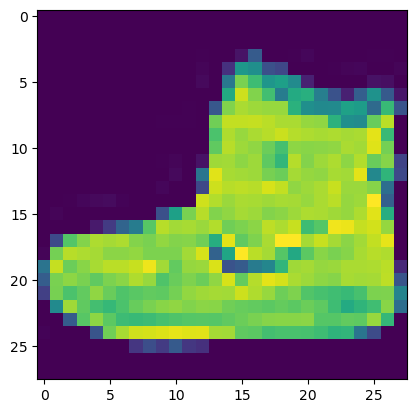

In [7]:
plt.imshow(image.squeeze())

But our dataset is in grayscale. So will convert to grayscale.

Text(0.5, 1.0, 'Ankle boot')

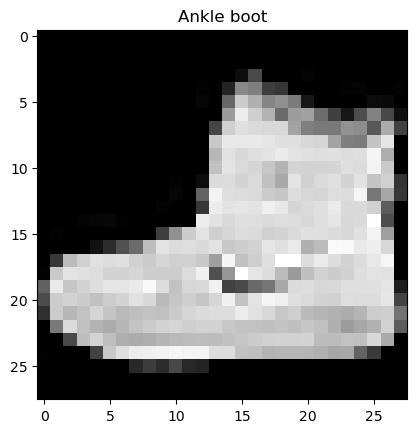

In [8]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])

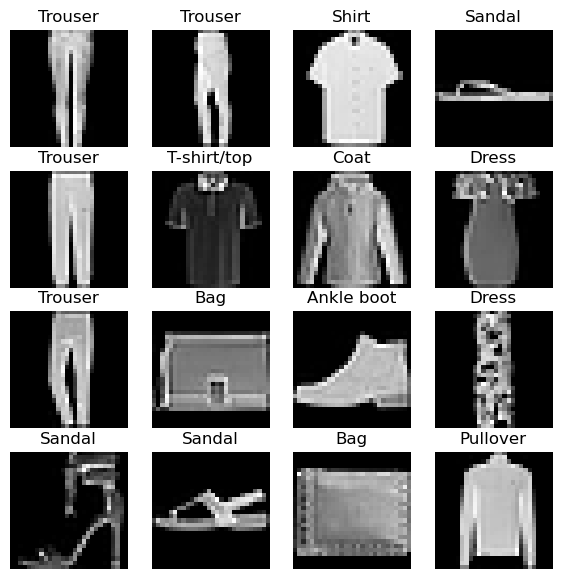

In [9]:
#View more images
fig = plt.figure(figsize=(7,7))
rows, cols = 4,4
for i in range(1, rows*cols + 1):
    rand = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand]
    fig.add_subplot(rows, cols, i)
    plt.title(class_names[label])
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis(False)

# Model Building

`DataLoader` is used to load the data to the model. It turn the dataset into a iterable of smaller data (batch size).

In [10]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True # This shuffles the data that way present batch is different from before batch
)

test_dataloader = DataLoader(
    test_data,
    batch_size = BATCH_SIZE #shuffle doesn't matter
)
len(train_dataloader)


1875

1875*32 should be around `len(train_data)`

In [11]:
class ModelOne(nn.Module):
    def __init__(self, input_shape: int, hidden_shape: int, output_shape: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Flatten(), #Explnation in below markdown
            nn.Linear(in_features=input_shape, out_features=hidden_shape),
            nn.ReLU(),
            nn.Linear(in_features=hidden_shape, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, X: torch.Tensor):
        return self.layers(X)

`nn.Flatten` makes the input into a single dimnesion by multiplying all other leaving the first dimension. Ex: Our input image is (1,28,28). Flatten wi;; return (1, 28*28) i.e (1,784).

As flatten outputs 784 as the second dim, `input_shape` = 784. `hidden_shape` is hyperprameter which represents number if nodes in each layer and `output_shape` is equal number of labels to be classified which in our case is 10 (len(class_names)).

In [12]:
model_1 = ModelOne(784, 10, len(class_names)).to(device) #Running on gpu if avail
next(model_1.parameters()).device

device(type='cuda', index=0)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
accuracy = Accuracy(task='multiclass', num_classes=10).to(device)


In [14]:
accuracy.device

device(type='cuda', index=0)

Will write a common train and test functions we can reuse for later models

In [15]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device #Default is gpu if avail
):
    train_loss = 0
    model.train() #Not mandatory as default is train
    #Data_Loader outputs X and y in batches
    for batch, (X_train,y_train) in enumerate(data_loader):
        #Use gpu if avail
        X_train, y_train = X_train.to(device), y_train.to(device)
        #Forward
        y_train_pred = model(X_train)
        #Loss
        loss = loss_fn(y_train_pred, y_train)
        train_loss += loss
        #backpropogation
        loss.backward()
        #Optimization
        optimizer.step()
        #Zero out the graidents
        optimizer.zero_grad()
        #Metric
        #batch_acc = accuracy(y_train_pred.softmax(dim=1), y_train)
        #print(f"Accuracy of batch {batch} is {batch_acc} and loss is {loss}")
    #train_acc = accuracy.compute()
    train_loss /= len(data_loader)
    print(f"Accuracy=and loss={train_loss}")


In [16]:
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn,
    device: torch.device = device
):
    test_loss = 0
    model.eval()
    with torch.inference_mode(): #Dont track derivates
        for X_test,y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            #Forward
            y_test_pred = model(X_test)
            #loss
            loss = loss_fn(y_test_pred, y_test)
            #Metrics
            test_loss += loss
            #acc = accuracy(y_test_pred.softmax(dim=1), y_test)
            
        #test_acc = accuracy.compute()
        test_loss /= len(data_loader)
        print(f"Accuracy= and loss={test_loss}")

Training and testing `model_1`

In [17]:
epochs = 3
for epoch in range(epochs):
    print(f"Epoch{epoch} Training")
    train_step(
        model_1,
        train_dataloader,
        loss_fn,
        optimizer
    )
    print(f"Epoch{epoch} Testing")
    test_step(
        model_1,
        test_dataloader,
        loss_fn
    )

Epoch0 Training
Accuracy=and loss=1.0807701349258423
Epoch0 Testing
Accuracy= and loss=0.9499874114990234
Epoch1 Training
Accuracy=and loss=0.894907534122467
Epoch1 Testing
Accuracy= and loss=0.909721851348877
Epoch2 Training
Accuracy=and loss=0.864648163318634
Epoch2 Testing
Accuracy= and loss=0.8873313069343567


## CNN model

Convolutional Neural Network have convolutional layers. In a fully connected layer, every node is connected to next layers node with some weight and bias. But in convolutional layer, only few neighbouring layers are connected to next layer nodes thus reducing the complexity and also giving sparse values in weight matrix. 
 
General Method:
1. Convolutional Layer:
    1. On the input image, a filter is convolved and this gives a matrix of convolution values in the dimension of `(n+1-m)*(n+1-m)` where nxn is image dimensions and mxm is filter. (If image is 3x32x32, filter is 3x6x6 then out=1x27x27).
    2. We repeat this step with different number of filters to capture multiple patterns creating multiple `channels`. One channels might be looking for edges, other for circles, ..
    3. Stacking all these convolution value matrices given a convolutional layer. (Say we have 64 filters/channels then conv layer = 27x27x**64**).
2. There might be an activation function.
2. As the conv layers are too big, we do pooling. Pooling reduces the dimension and can be interpreted as **This filter had a high response in this general region**. Popular pooling technique is `Max_Pooling` where the ouput has only the max value of a neighborhood. Its a pool of maximum values in their respective neighbourhoods. (Take one convoluted matrix of size 4x4, we apply a maxpool with 2x2 filter (a max value is considered for a 2x2 neighbourhood) and stride 2 (how many spaces to move the filter to get new neighbourhood), then the out = 2x2).
3. This conv layer + activation func and pooling will be repeated based on the depth of architecture.
3. The output matrix of values are flattened into a single vector of `(prod of dim) x 1`.
4. There might be few fully connected layers later and then an activation function.  

Depending on the architecture, number of layers (depth), number of nodes per layer (width) and respective weights and biases change.


Understanding Hyerparamters  (https://poloclub.github.io/cnn-explainer/)
1. Kernel Size  
    It is the size of the filter to be applied. It slides over the input cnvolving and giving convoluted image. Size of the kernel is inversely proportional to the depth of the layer. Generally small kernel learns more.
2. Stride  
    How to move the filter. Say if stride is 1 then filter is moved by 1 row/column (pixels). Impact of stride is similar to Kernel size lesser the size more the model learns.
3. Padding  
    If the some kernel size filter is moving by some stride, then there might be a chance at the image boundaries where the filter exceeds the boundaries with given stride. If padding isn't there, those boundary pizels are ignored. Padding preserves those pixels thereby completely learning about the input image. Extra pixels are created along the boundaries of the image and some value is given to those pixels (generally zero).

Lets create TinyVGG ((conv+relu+conv+relu+maxpool)*2)

In [18]:
class ModelTwo(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape) -> None:
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels = input_shape,
                out_channels = hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ), #dont forget comma
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size=1,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = 2,
                stride = 2
            )
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(
                hidden_units,
                hidden_units,
                3, #Kernel Size
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2) #stride default is value same as kernel size
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units*7*7, #Flatten multiplies all dim| 7*7 got by print in forward()
                out_features = output_shape
            )
        )
    
    def forward(self, X: torch.Tensor):
        X = self.block1(X)
        X = self.block2(X)
        print(X.shape)
        X = self.classifier(X)
        return X

In [19]:
model_2 = ModelTwo(1,10,len(class_names)).to(device)
model_2

ModelTwo(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [20]:
loss_fn = nn.CrossEntropyLoss
optimizer = torch.optim.SGD(
    params = model_2.parameters(),
    lr = 0.1
)

In [21]:
#Using train_step and test_step functions
epochs = 3
for epoch in range(epochs):
    train_step(
        model_2,
        train_dataloader,
        loss_fn,
        optimizer
    )
print("Testing")
test_step(model_2,test_dataloader, loss_fn)

: 

: 